In [18]:
# import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["font.family"] = "serif"
import seaborn as sns
import os
import datetime as dt
# enable copy on write (default in pandas 3.0)
pd.options.mode.copy_on_write = True

In [2]:
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline
import joblib

In [3]:
def read_merged(weather, year):
    return pd.read_csv('../../merged/merged_{}_{}.csv.gz'.format(weather, year))
meso = [read_merged("mesocyclone", year) for year in range(2015, 2024)]
data = pd.concat(meso)
del data['Unnamed: 0']
del data['index']
del data['Event Month']
del data['Month']
data['TVS_max'] = 1*(data['TVS_max'] == 'Y')
data['DATE'] = pd.to_datetime(data['DATE'])
data['MONTH'] = data['DATE'].dt.month

/tmp/ipykernel_6347/2447030641.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv('../../merged/merged_{}_{}.csv.gz'.format(weather, year))
/tmp/ipykernel_6347/2447030641.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv('../../merged/merged_{}_{}.csv.gz'.format(weather, year))
/tmp/ipykernel_6347/2447030641.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv('../../merged/merged_{}_{}.csv.gz'.format(weather, year))
/tmp/ipykernel_6347/2447030641.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv('../../merged/merged_{}_{}.csv.gz'.format(weather, year))
/tmp/ipykernel_6347/2447030641.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=F

In [5]:
newnames = {'LAT_mean':'LAT', 'LON_mean':'LON', 'LL_ROT_VEL_max':'LL_ROT_VEL', 'DPTH_STMRL_max':'DPTH_STMRL', 
            'LL_BASE_max':'LL_BASE', 'DEPTH_KFT_max':'DEPTH_KFT', 'MAX_RV_KFT_max':'MAX_RV_KFT',
            'LL_DV_max':'LL_DV', 'DPTH_STMRL_max':'DPTH_STMRL', 'MAX_RV_KTS_max':'MAX_RV_KTS', 'TVS_max':'TVS', 'MSI_max':'MSI',
           'county':'COUNTY', 'state':'STATE', 'power_outage':'POWER_OUTAGE'}
data = data.rename(columns=newnames)


In [6]:
meso_train, meso_test = train_test_split(data, test_size=0.2, stratify=data.POWER_OUTAGE, random_state=5)
meso_tt, meso_val = train_test_split(meso_train, test_size=0.2, stratify=meso_train.POWER_OUTAGE)
outage = meso_tt[meso_tt['POWER_OUTAGE']==True]
no_outage = meso_tt[meso_tt['POWER_OUTAGE']==False]
no_outage= no_outage.sample(n=len(outage), random_state=101)
balanced = pd.concat([outage,no_outage],axis=0)

In [18]:
xgb_clf = xgboost.XGBClassifier(objective= 'binary:logistic', learning_rate=0.01, max_depth=16, n_estimators=440)
rf_clf =  RandomForestClassifier(n_estimators=300, max_depth=13)
#xgb_model = Pipeline([('resampler', RandomUnderSampler()), ('clf',xgb_clf)])
#rf_model = Pipeline([('resampler', RandomUnderSampler()), ('clf', rf_clf)])
logistic_model = Pipeline([('scaler',StandardScaler()), ('logistic', LogisticRegression(C=0.1))])


In [20]:
balanced.columns

Index(['DATE', 'LAT', 'LON', 'STR_RANK_max', 'LL_ROT_VEL', 'LL_DV',
       'LL_BASE_max', 'DEPTH_KFT_max', 'DPTH_STMRL', 'MAX_RV_KFT_max',
       'MAX_RV_KTS', 'TVS', 'MSI', 'COUNTY', 'STATE', 'MONTH', 'POWER_OUTAGE',
       'Event Month'],
      dtype='object')

In [7]:
features_n = ['MONTH', 'LAT', 'LON', 'LL_ROT_VEL', 'LL_DV', 'LL_BASE', 'DEPTH_KFT', 'DPTH_STMRL',
            'MAX_RV_KFT', 'MAX_RV_KTS', 'TVS', 'MSI']
features = ['LAT', 'LON', 'LL_ROT_VEL',
       'LL_DV', 'DPTH_STMRL', 'MAX_RV_KTS', 'TVS', 'MSI','MONTH']

### If not saved

In [ ]:
models = {'xgboost_v2': xgb_clf, 'RandomForest_v2': rf_clf, 'LogisticRegression': logistic_model}
for name, model in models.items():
    model.fit(balanced[features], balanced['POWER_OUTAGE'])
    joblib.dump(model,'../../models/{}_meso.pkl'.format(name))
    

## Once saved

In [8]:
xgb = joblib.load('../../models/xgb_meso.pkl')
rf = joblib.load('../../models/rf_meso.pkl')
xgb_y = joblib.load('../../models/xgb_v2_meso.pkl')
logistic = joblib.load('../../models/LogisticRegression_meso.pkl')
rf_m = joblib.load('../../models/RandomForest_v2_meso.pkl')

In [9]:
models = {'xgboost':xgb, 'RandomForest':rf, 'xgboost_v2': xgb_y,'RandomForest_v2': rf_m, 'LogisticRegression': logistic}

In [10]:
precisions, recalls, predictions ={}, {}, {}

In [11]:
for name, model in models.items():
    if name == 'xgboost_v2' or name == 'RandomForest_v2' or name == 'LogisticRegression':
        preds = model.predict(meso_val[features])
        predictions[name] = preds
        recalls[name] = recall_score(meso_val['POWER_OUTAGE'], preds)
        precisions[name] = precision_score(meso_val['POWER_OUTAGE'], preds)
        
    else:
        preds = model.predict(meso_val[features_n])
        predictions[name] = preds
        precisions[name] = precision_score(meso_val['POWER_OUTAGE'], preds)
        recalls[name] = recall_score(meso_val['POWER_OUTAGE'], preds)



In [13]:
for name in models:
    print(f"Precision for {name} is {precisions[name]}")
    print(f"Recall for {name} is {recalls[name]}")

Precision for xgboost is 0.15809585135541596
Recall for xgboost is 0.9345871628559265
Precision for RandomForest is 0.1199847049786648
Recall for RandomForest is 0.8879817685507501
Precision for xgboost_v2 is 0.14538656365025618
Recall for xgboost_v2 is 0.9387192907765897
Precision for RandomForest_v2 is 0.9117117117117117
Recall for RandomForest_v2 is 0.012671858956700309
Precision for LogisticRegression is 0.0638744508903122
Recall for LogisticRegression is 0.7155342966617415


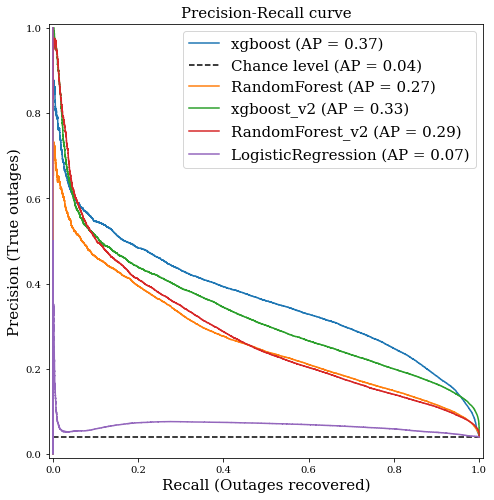

In [14]:
from sklearn.metrics import PrecisionRecallDisplay
fig, ax = plt.subplots(figsize=(12, 8))
for name, model in models.items():
    if name == 'xgboost_v2' or name == 'RandomForest_v2' or name == 'LogisticRegression':
        display = PrecisionRecallDisplay.from_estimator(
        model, meso_val[features], meso_val['POWER_OUTAGE'], 
            plot_chance_level=name=='xgboost', ax=ax, name=name)
    else:
        display = PrecisionRecallDisplay.from_estimator(
        model, meso_val[features_n], meso_val['POWER_OUTAGE'], 
            plot_chance_level=name=='xgboost', ax=ax, name=name)
_ = display.ax_.set_title("Precision-Recall curve", size=15)      
_ = display.ax_.legend(loc='upper right', fontsize=15)      
_ = display.ax_.set_xlabel('Recall (Outages recovered)', size=15)      
_ = display.ax_.set_ylabel('Precision (True outages)', size=15)      

plt.savefig("../../figures/meso_model_comparison.png", dpi=500, bbox_inches='tight',
            facecolor='white', transparent=False)
     


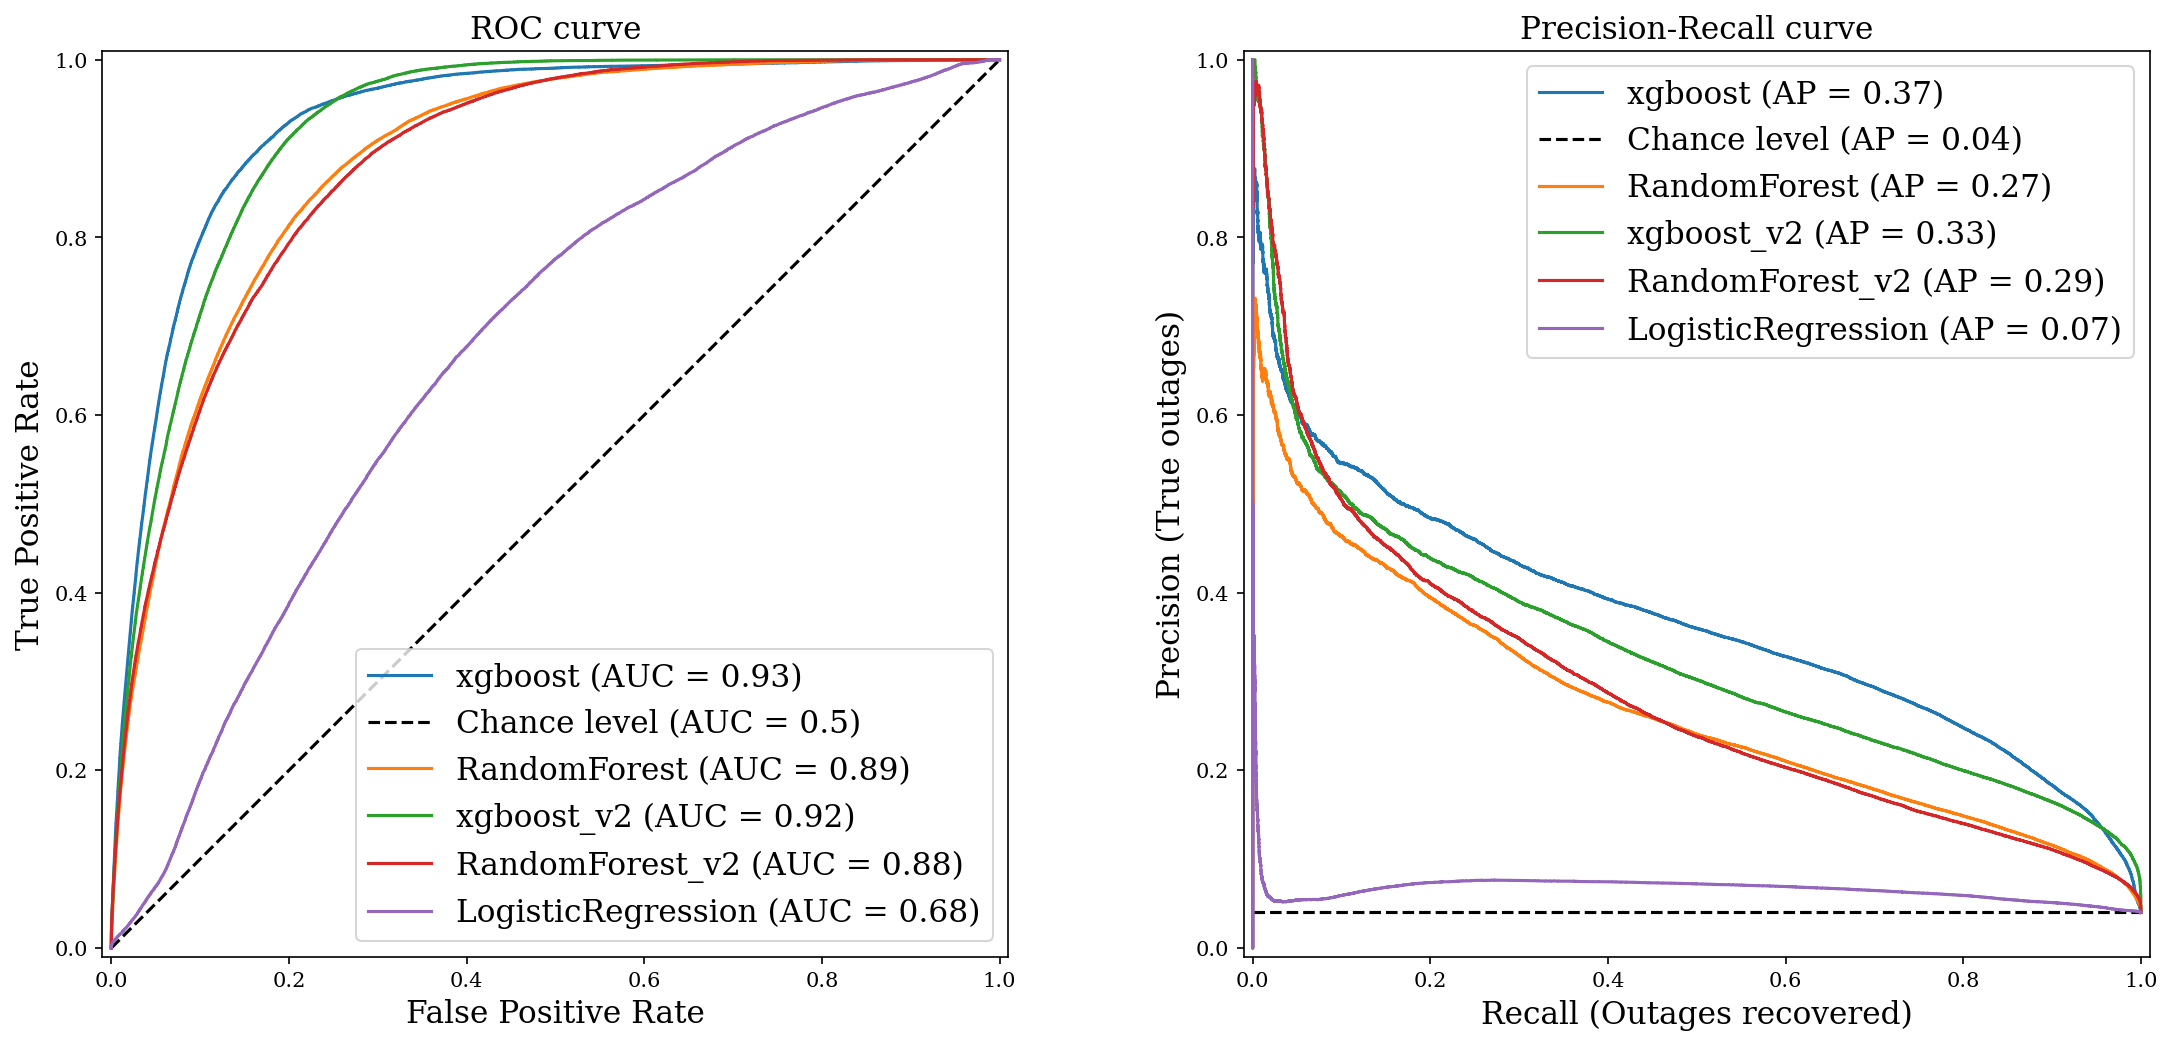

In [22]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
fig, axs = plt.subplots(1, 2, figsize=(18, 8))
for name, model in models.items():
    if name == 'xgboost_v2' or name == 'RandomForest_v2' or name == 'LogisticRegression':
        display = PrecisionRecallDisplay.from_estimator(
        model, meso_val[features], meso_val['POWER_OUTAGE'], 
            plot_chance_level=name=='xgboost', ax=axs[1], name=name)
        display2 = RocCurveDisplay.from_estimator(
        model, meso_val[features], meso_val['POWER_OUTAGE'], 
            plot_chance_level=name=='xgboost', ax=axs[0], name=name)
    else:
        display = PrecisionRecallDisplay.from_estimator(
        model, meso_val[features_n], meso_val['POWER_OUTAGE'], 
            plot_chance_level=name=='xgboost', ax=axs[1], name=name)
        display2 = RocCurveDisplay.from_estimator(
        model, meso_val[features_n], meso_val['POWER_OUTAGE'], 
            plot_chance_level=name=='xgboost', ax=axs[0], name=name)
_ = display.ax_.set_title("Precision-Recall curve", size=15)      
_ = display.ax_.legend(loc='upper right', fontsize=15)      
_ = display.ax_.set_xlabel('Recall (Outages recovered)', size=15)      
_ = display.ax_.set_ylabel('Precision (True outages)', size=15)      


_ = display2.ax_.set_title("ROC curve", size=15)      
_ = display2.ax_.legend(loc='lower right', fontsize=15)      
_ = display2.ax_.set_xlabel('False Positive Rate', size=15)      
_ = display2.ax_.set_ylabel('True Positive Rate', size=15)

plt.savefig("../../figures/meso_roc_pr_model_comparison.png", dpi=500, bbox_inches='tight',
            facecolor='white', transparent=False)



# Results on test

In [12]:
best_model = models['xgboost']

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


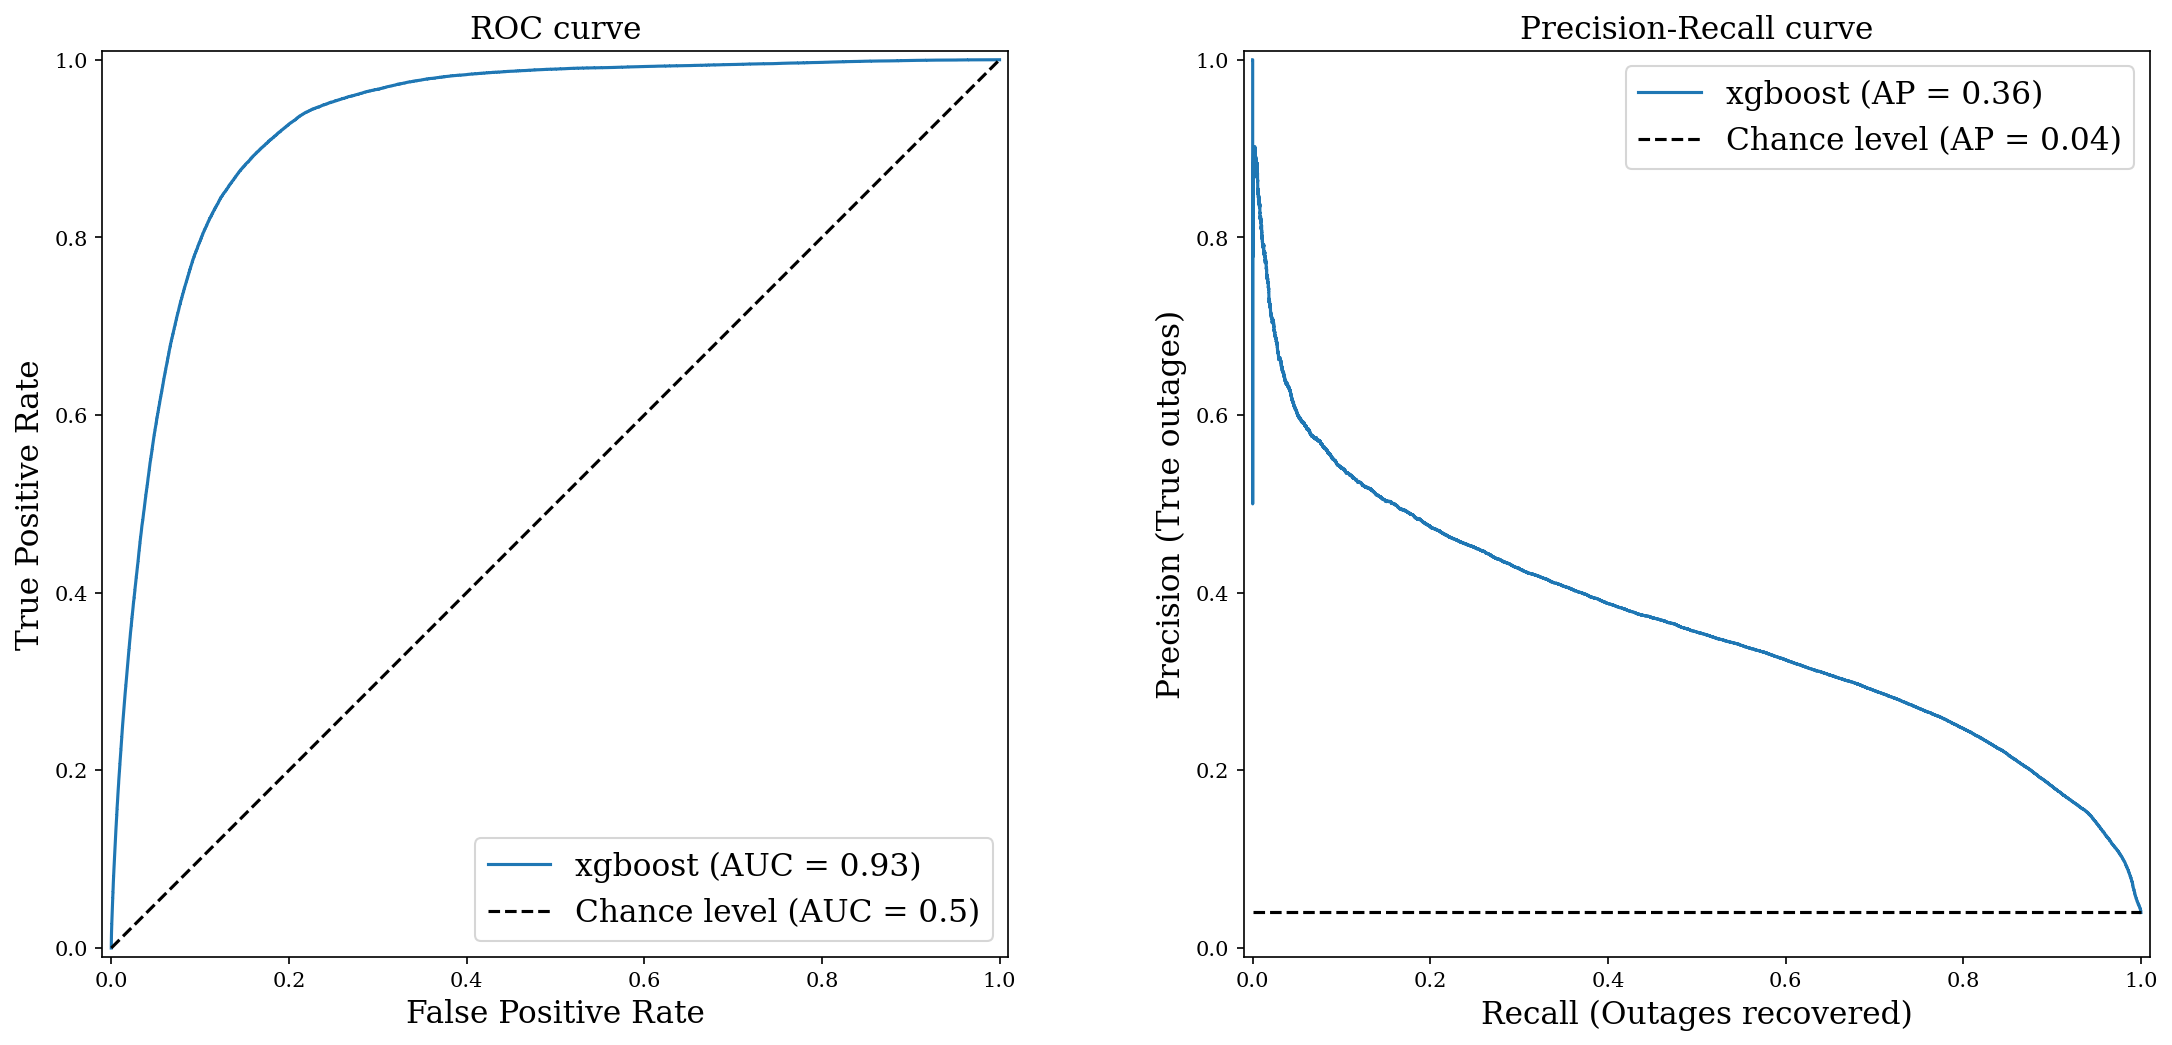

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))
display = PrecisionRecallDisplay.from_estimator(
        best_model, meso_test[features_n], meso_test['POWER_OUTAGE'], 
            plot_chance_level=True, ax=axs[1], name='xgboost')
display2 = RocCurveDisplay.from_estimator(
        best_model, meso_test[features_n], meso_test['POWER_OUTAGE'], 
            plot_chance_level=True, ax=axs[0], name='xgboost')

_ = display.ax_.set_title("Precision-Recall curve", size=15)      
_ = display.ax_.legend(loc='upper right', fontsize=15)      
_ = display.ax_.set_xlabel('Recall (Outages recovered)', size=15)      
_ = display.ax_.set_ylabel('Precision (True outages)', size=15)      


_ = display2.ax_.set_title("ROC curve", size=15)      
_ = display2.ax_.legend(loc='lower right', fontsize=15)      
_ = display2.ax_.set_xlabel('False Positive Rate', size=15)      
_ = display2.ax_.set_ylabel('True Positive Rate', size=15)

plt.savefig("../../figures/meso_roc_pr_test_results.png", dpi=500, bbox_inches='tight',
            facecolor='white', transparent=False)

# Feature importance

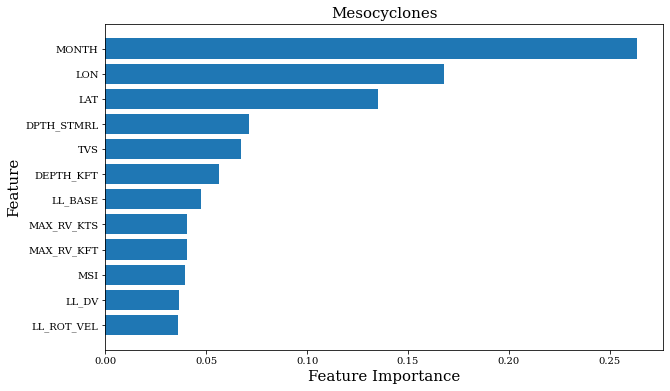

In [13]:
def plot_feature_importance(model, feature_names):
    # Get feature importance scores from the model
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]
    sorted_feature_names = [feature_names[i] for i in indices]
    sorted_importance = importance[indices]
    

    # Create bar plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), sorted_importance, align='center')
    plt.yticks(range(len(indices)), sorted_feature_names)
    plt.xlabel('Feature Importance', size=15)
    plt.ylabel('Feature', size=15)
    plt.title('Mesocyclones', size=15)
    plt.gca().invert_yaxis()  # Invert y-axis for better visualization
    plt.savefig("../../figures/meso_feature_importance.png", dpi=500, bbox_inches='tight',
            facecolor='white', transparent=False)
    plt.show()
plot_feature_importance(best_model['clf'], features_n)

# Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

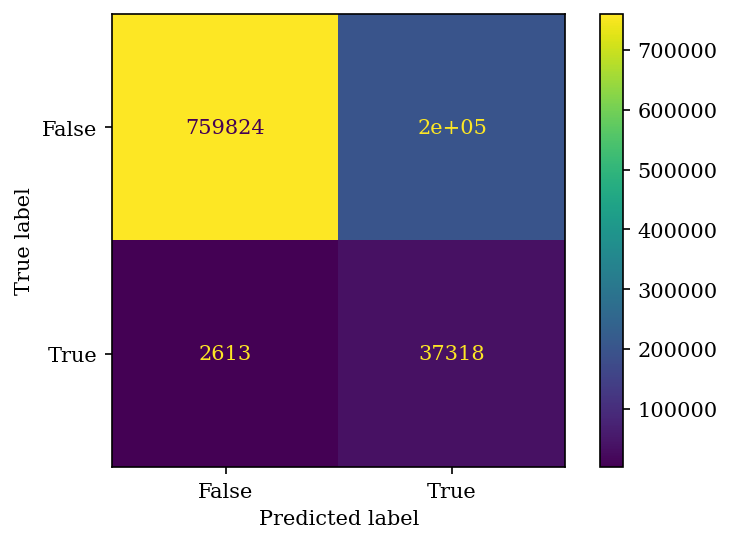

In [55]:
ConfusionMatrixDisplay.from_predictions(meso_val['POWER_OUTAGE'], predictions['xgboost'])

# Confusion matrix with a different threshold

In [14]:
probas = best_model.predict_proba(meso_val[features_n])

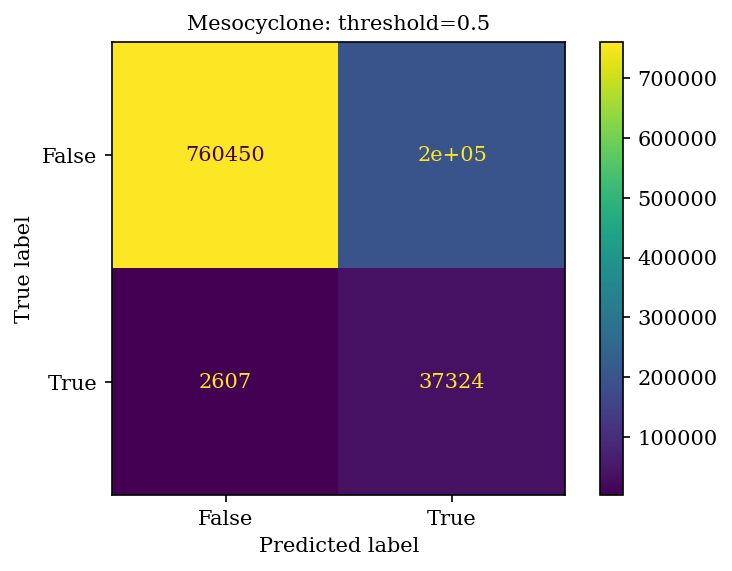

In [20]:
thr = 0.5
display = ConfusionMatrixDisplay.from_predictions(meso_val['POWER_OUTAGE'], probas[:,1]>thr)

_ = display.ax_.set_title("Mesocyclone: threshold={}".format(thr), size=10)      
plt.savefig("../../figures/meso_confusion_matrix_thr_{:1.0f}.png".format(10*thr), dpi=500, bbox_inches='tight',
            facecolor='white', transparent=False)